In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
# get some random training images
for dataiter in train_loader:
    images, labels = dataiter
    break

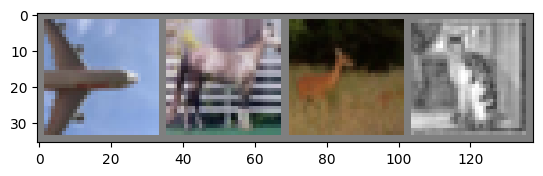

In [11]:
# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
images.shape, labels.shape   #4=>batch size, 3=> channel, 32x32=>image dim

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [13]:
# Convolutional Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()         #[4, 3, 32, 32]
        self.conv1 = nn.Conv2d(3, 6, 5)         # input size, output size, kernel size # [4, 6, 28, 28]
        self.pool = nn.MaxPool2d(2, 2)          # [4, 6, 14, 14]
        self.conv2 = nn.Conv2d(6, 16, 5)        # [4, 16, 10, 10]
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # [4, 16, 5, 5] <= Out of 2nd max pool applied in forward() method
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400  #To flatten: view() method is used
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

In [14]:
model = ConvNet().to(device)
model

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
n_total_steps

12500

In [16]:
# Training
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()   # gradient cal
        optimizer.step()  # weight update

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3192
Epoch [1/5], Step [4000/12500], Loss: 2.3204
Epoch [1/5], Step [6000/12500], Loss: 2.2696
Epoch [1/5], Step [8000/12500], Loss: 2.3098
Epoch [1/5], Step [10000/12500], Loss: 2.2924
Epoch [1/5], Step [12000/12500], Loss: 2.3778
Epoch [2/5], Step [2000/12500], Loss: 2.1630
Epoch [2/5], Step [4000/12500], Loss: 1.6757
Epoch [2/5], Step [6000/12500], Loss: 2.4182
Epoch [2/5], Step [8000/12500], Loss: 1.7872
Epoch [2/5], Step [10000/12500], Loss: 2.0347
Epoch [2/5], Step [12000/12500], Loss: 1.8284
Epoch [3/5], Step [2000/12500], Loss: 2.2080
Epoch [3/5], Step [4000/12500], Loss: 0.8362
Epoch [3/5], Step [6000/12500], Loss: 1.8978
Epoch [3/5], Step [8000/12500], Loss: 1.7393
Epoch [3/5], Step [10000/12500], Loss: 1.6272
Epoch [3/5], Step [12000/12500], Loss: 1.2654
Epoch [4/5], Step [2000/12500], Loss: 2.1809
Epoch [4/5], Step [4000/12500], Loss: 1.9024
Epoch [4/5], Step [6000/12500], Loss: 1.9757
Epoch [4/5], Step [8000/12500], Loss: 2.0495
Epoc

In [17]:
#Testing
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 47.83 %
Accuracy of plane: 42.7 %
Accuracy of car: 59.7 %
Accuracy of bird: 13.9 %
Accuracy of cat: 33.5 %
Accuracy of deer: 37.2 %
Accuracy of dog: 44.7 %
Accuracy of frog: 58.0 %
Accuracy of horse: 61.8 %
Accuracy of ship: 66.6 %
Accuracy of truck: 60.2 %
